In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rfpimp import *
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
df = pd.read_csv('employee_retention_data.csv')

In [4]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [5]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [6]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

From a preliminary look at the data, we can see that some descriptive stats about median/mean pay and seniority. We also see that there are 11,192 people who haven't quit yet. These people may be useful to look at later too!

I'll convert the join and quit dates as datetime values so that we can easily calculate how long they have been at the company. Prediction church is more than predicting __if__ someone will leave. We also want to maximize how long they will stay.

In [7]:
df['join_as_date'] = pd.to_datetime(df.join_date)

In [8]:
df['quit_as_date'] = pd.to_datetime(df.quit_date)

In [9]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_as_date,quit_as_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2011-10-17,2014-08-22


We can also give a time at the company to people who are missing a quit value. To do this, we will have a column that is a boolean of whether or not they have quit, and then impute the date of the survey to everyone else by filling na's. 

In [10]:
df['quit_bool'] = ~df.quit_as_date.isnull()

In [11]:
a = pd.datetime(2015,12,13)

In [12]:
df.quit_as_date.fillna(a, inplace=True)

I don't think we need the dates as numbers/strings anymore, so let's make a new dataframe without those.

In [13]:
data = df[['employee_id','company_id','dept','seniority','salary','join_as_date','quit_as_date','quit_bool']]

And now we can calculate time at company

In [14]:
data['time_at_company'] = data['quit_as_date']-data['join_as_date']

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_as_date,quit_as_date,quit_bool,time_at_company
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,False,426 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040 days


In [16]:
data.describe()

,employee_id,company_id,seniority,salary,time_at_company
count,24702.000000,24702.000000,24702.000000,24702.000000,24702
mean,501604.403530,3.426969,14.127803,138183.345478,574 days 07:39:28.812241
std,288909.026101,2.700011,8.089520,76058.184573,361 days 14:13:01.578145
min,36.000000,1.000000,1.000000,17000.000000,3 days 00:00:00
25%,250133.750000,1.000000,7.000000,79000.000000,333 days 00:00:00
50%,500793.000000,2.000000,14.000000,123000.000000,424 days 00:00:00
75%,753137.250000,5.000000,21.000000,187000.000000,781 days 00:00:00
max,999969.000000,12.000000,99.000000,408000.000000,1777 days 00:00:00


In [17]:
 data['time_delta_int'] = data.time_at_company.astype('timedelta64[D]')

(array([2.950e+02, 1.870e+02, 2.950e+02, 2.010e+02, 2.860e+02, 1.840e+02,
        2.700e+02, 2.130e+02, 2.960e+02, 2.070e+02, 2.690e+02, 2.130e+02,
        2.770e+02, 2.920e+02, 2.690e+02, 4.360e+02, 4.620e+02, 8.870e+02,
        1.267e+03, 1.241e+03, 1.673e+03, 1.164e+03, 1.024e+03, 5.890e+02,
        4.010e+02, 2.700e+02, 1.500e+02, 1.790e+02, 1.790e+02, 1.340e+02,
        1.980e+02, 1.510e+02, 2.700e+02, 2.610e+02, 2.990e+02, 3.400e+02,
        3.180e+02, 4.010e+02, 3.850e+02, 5.010e+02, 3.990e+02, 5.110e+02,
        3.420e+02, 4.300e+02, 3.110e+02, 2.940e+02, 2.230e+02, 2.480e+02,
        1.710e+02, 1.530e+02, 1.390e+02, 1.630e+02, 1.460e+02, 1.560e+02,
        1.540e+02, 1.480e+02, 1.910e+02, 1.380e+02, 2.090e+02, 1.540e+02,
        1.970e+02, 1.430e+02, 2.020e+02, 1.690e+02, 1.610e+02, 1.530e+02,
        1.380e+02, 1.370e+02, 1.060e+02, 1.140e+02, 1.010e+02, 1.020e+02,
        8.600e+01, 1.120e+02, 9.400e+01, 8.500e+01, 8.500e+01, 9.800e+01,
        9.200e+01, 7.000e+01, 8.500e+0

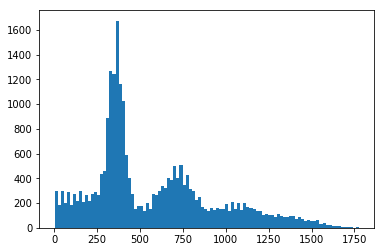

In [18]:
plt.hist(data.time_delta_int, bins=100)

### Time at company in days.
There's an interesting and logical distribution of how long people are staying- we see a huge peak of people who only stay at their job for one year, a second peak at two years, and then a tiny bump at three years. Things trail off from there.

What does this tell us!? First, that **the first year is important** - most people are leaving after just about one year. If we want to do something to improve retention, the first year looks like a good place to start. There's also another bump at just about two years, so the second year seems to be pretty important too.

Let's make sure that this isn't just a bias in the data. The previous chart was all employee, but let's look at the time spent at company only for people who have quit, and then only for people who have not yet quit.

(array([1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 3.000e+00,
        6.000e+00, 6.000e+00, 1.100e+01, 4.700e+01, 8.300e+01, 1.710e+02,
        4.710e+02, 5.820e+02, 8.480e+02, 1.419e+03, 1.043e+03, 9.490e+02,
        8.920e+02, 3.970e+02, 2.250e+02, 1.280e+02, 3.200e+01, 1.100e+01,
        9.000e+00, 1.400e+01, 2.100e+01, 3.200e+01, 3.400e+01, 6.300e+01,
        9.500e+01, 1.380e+02, 1.390e+02, 1.810e+02, 2.440e+02, 1.970e+02,
        2.630e+02, 3.510e+02, 2.710e+02, 2.760e+02, 3.130e+02, 2.180e+02,
        2.120e+02, 1.860e+02, 1.340e+02, 1.120e+02, 1.140e+02, 4.100e+01,
        4.600e+01, 4.700e+01, 6.800e+01, 6.000e+01, 6.100e+01, 7.700e+01,
        5.300e+01, 5.700e+01, 9.700e+01, 8.200e+01, 8.600e+01, 1.060e+02,
        7.500e+01, 8.200e+01, 1.000e+02, 8.800e+01, 8.700e+01, 9.400e+01,
        7.000e+01, 6.100e+01, 7.600e+01, 4.700e+01, 5.100e+01, 5.500e+01,
        3.400e+01, 4.500e+01, 4.600e+01, 5.200e+01, 4.300e+01, 4.500e+01,
        5.000e+01, 4.800e+01, 3.700e+0

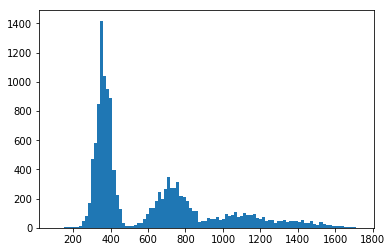

In [19]:
plt.hist(data[data['quit_bool']==True].time_delta_int, bins=100)

(array([295., 187., 295., 201., 286., 183., 269., 210., 292., 203., 264.,
        207., 271., 278., 220., 300., 187., 289., 198., 248., 149., 217.,
        113., 181., 135., 191., 116., 172., 160., 120., 163., 119., 199.,
        123., 202., 127., 144., 127., 160., 117., 152., 123.,  93., 135.,
         88., 113.,  76., 114.,  74., 108.,  76., 108.,  73.,  98.,  69.,
         94., 103.,  68.,  94.,  68.,  95.,  55.,  94.,  57.,  74.,  56.,
         68.,  46.,  57.,  43.,  63.,  47.,  37.,  56.,  48.,  32.,  38.,
         47.,  28.,  36.,  28.,  36.,  21.,  29.,  18.,  24.,  24.,  10.,
         16.,  10.,  13.,   4.,   8.,   8.,   4.,   4.,   3.,   2.,   1.,
          7.]),
 array([   3.  ,   20.74,   38.48,   56.22,   73.96,   91.7 ,  109.44,
         127.18,  144.92,  162.66,  180.4 ,  198.14,  215.88,  233.62,
         251.36,  269.1 ,  286.84,  304.58,  322.32,  340.06,  357.8 ,
         375.54,  393.28,  411.02,  428.76,  446.5 ,  464.24,  481.98,
         499.72,  517.46,  535.2 ,

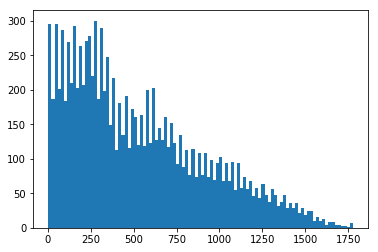

In [20]:
plt.hist(data[data['quit_bool']==False].time_delta_int, bins=100)

So, it looks like people who quit are indeed quitting at very distinct times (around 1 or two years). People who are still employed have been at their jobs at pretty evenly distributed times until about a year, and then there's a step down. Then another step down around two years. This is another strong indicators that people tend to quit after getting a certain amount of experience/time at a company.

There are lots of things that could be going on here that we can't yet test. Are these people getting a yearly performance review and not doing well? Maybe people have decided to leave long before the year ends, but stay there until they feel like an acceptable amount of time has passed that it won't reflect negatively on them. Lots of places where some more data would be useful.

### Do we see the same time spent at a company for all companies and across all departments?

It could be that some companies are better than others at retaining employees. Let's look at how long people stay at each company.

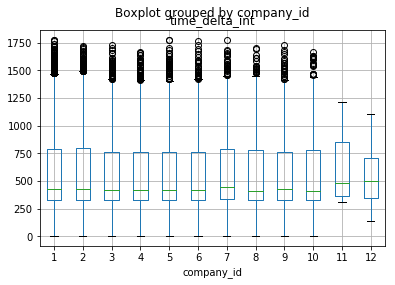

In [21]:
data.boxplot(column='time_delta_int', by='company_id')

It looks like companies 11 and 12 might have something interesting going on. Their median time of employment is higher, and they have much shorter tails of people leaving quickly. One possible recommendation is to look into the practices of these companies and determine what they are doing differently.

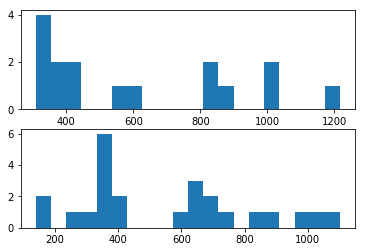

In [22]:
#do the normal distributions for 11 and 12 hold true?
subset = data[data['company_id']==11]
plt.subplot(2,1,1)
plt.hist(subset.time_delta_int, bins =20)

subset = data[data['company_id']==12]
plt.subplot(2,1,2)
plt.hist(subset.time_delta_int, bins = 20)

plt.show()

From the above, it looks like the two companies that had higher median time at company are small companies. It may be that company size is an important feature. Let's check company size for each company

In [23]:
data.company_id.value_counts()

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

Indeed, we can confirm that companies 11 and 12 are much smaller than all the other companies. So either there is something about being a small company that allows you to retain people for slightly longer, or they simply don't have enough samples. This is hard to distinguish, because we can't hold factors constant and only vary the number of employees. Company culture and experience change with size in real life.

In [24]:
#since company size could be a useful feature, we will add it here to our dataframe
data['company_size']=0

for x, y in enumerate(data.company_id.value_counts()):
    data.loc[data['company_id']==x+1, 'company_size']= y


In [25]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_as_date,quit_as_date,quit_bool,time_at_company,time_delta_int,company_size
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585 days,585.0,1224
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340 days,340.0,1224
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,False,426 days,426.0,2062
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389 days,389.0,1224
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040 days,1040.0,4222


Now let's check by department how long people are staying

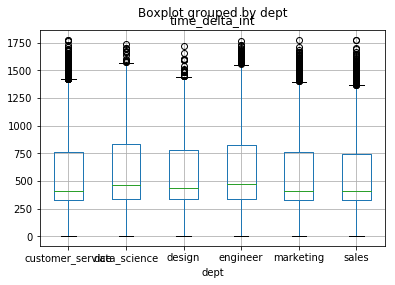

In [26]:
data.boxplot(column='time_delta_int', by='dept')

Engineers and data scientists tend to stay slightly longer than other departments.

We've looked at a few specific hypotheses so far, but let's see if we can pull any correlations out of the data.
We need to convert some of the categorical variables to values in order to get correlations. This can be done through one-hot encoding or by changing the categories into a number. Because we aren't dealing with high-cardinality for most of these, we will one-hot encode them.

### Look at all other correlations
We can check to see if there are any other correlations with the length of time someone stays at the company, since that's what we want to maximize. To do this, we'll make one-hot columns for each department and company (because these are categorical data), and make a correlation table. Then, we will look at the correlation between each variable and time at company

In [27]:
data['company_id_cat'] = data.company_id.astype('category')


In [28]:
one_hots = pd.get_dummies(data)

In [29]:
corr = one_hots.corr()

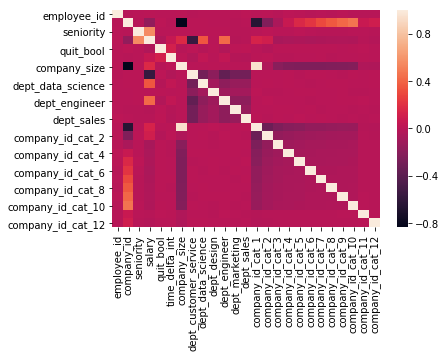

In [30]:
sns.heatmap(corr)

In [31]:
corr.time_delta_int.sort_values()

dept_customer_service   -0.027163
dept_sales              -0.022616
dept_marketing          -0.015712
company_id              -0.009987
company_id_cat_3        -0.009677
company_id_cat_4        -0.009132
company_id_cat_8        -0.006141
company_id_cat_6        -0.004732
company_id_cat_5        -0.003184
company_id_cat_9        -0.002905
company_id_cat_10       -0.002120
company_id_cat_12       -0.001961
employee_id             -0.001777
dept_design             -0.000697
seniority                0.000742
company_id_cat_11        0.002930
company_id_cat_7         0.005358
company_id_cat_1         0.007593
company_size             0.011070
company_id_cat_2         0.012875
dept_data_science        0.034372
dept_engineer            0.037408
salary                   0.053914
quit_bool                0.119012
time_delta_int           1.000000
Name: time_delta_int, dtype: float64

If we look at a list of all of the factors correlated with "time at company":
the most strongly correlated factors tend to be salary and being an whether or not that person is an engineer/data scientist. 

The most strongly correlated factor (whether or not they have quit) simply indicates that the longer someone has spent at a company, the more likely they are to have quit. No surprises there.

Another interesting factor is strong negative correlation of being in sales and customer service and time at company. This tells us that people who are in these departments turn over more quickly.

### Let's look at salary and time at company

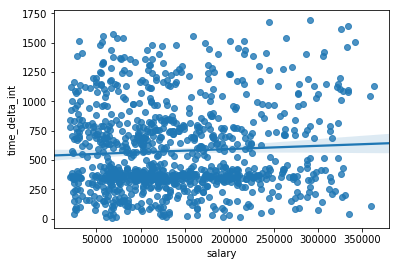

In [42]:
# plt.scatter(data.salary, data.time_delta_int)
plot = one_hots.sample(1000)
ax = sns.regplot(x="salary", y="time_delta_int", data=plot)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


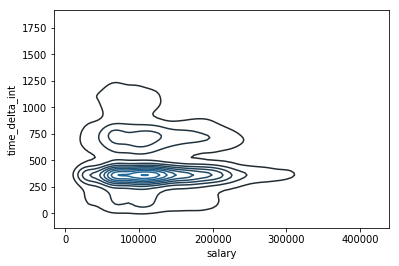

In [43]:
sns.kdeplot(one_hots.salary, one_hots.time_delta_int)

Above, we see a chart that displays the density plot of salary vs time at company. Despite increasing salaries, we don't see a strong increase in the number of days that someone stays at the company.

We know that there is a positive relationship, as plotted above, but it doesn't look very strong.

There also still exists the pattern where lots of people are leaving at around a year, and then another group at around two years. The horizontal blob means that people are only staying this long along lots of different salaries.

### One more look at Salary
So far, we have seen that salary is associated with a slight increase in time at company, and that customer service jobs have the highest turnover. Let's look specifically to see if increasing salary in customer service jobs is associated with a longer time at the company

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


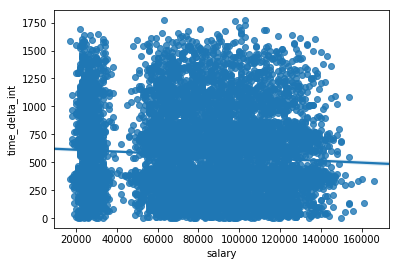

In [44]:
x = data[data['dept']=='customer_service']
ax = sns.regplot(x="salary", y="time_delta_int", data=x)

Hot dang! There's actually a slight negative correlation between salary and time spent at company in customer service jobs. This means that our intuition to try to pay them more is **wrong**

# Conclusions:
1. People leave cyclically. Most people leave after a year, and then another group after two. 
2. Salary and type of position are the main drivers **within the data that we have**, but they are not highly predictive. Getting paid more and being an Engineer/Data scientist are correlated with staying longer. Being in customer service is correlated with staying for **less** time.

# Recommended Actions:
1. Make people really enjoy their first year of work. Better to make the first two years great.
2. Help make life better for customer service workers, but don't do that by paying them more. Survey them to see what would make their life at work better.

# Helpful Data for the Future:
It would be wonderful to know the performance review for each employee. I hypothesize that people who are succeeding in performance reviews are more likely to stay at their current company.
 